In [3]:
# Импорт необходимых библиотек
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sklearn as sk
from keras.layers import Dropout
from sklearn import metrics

In [5]:
# Подготовка данных для LSTM
def prepare_data(series, look_back=4):
    """
    Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back
    В результает метод возвращает массив Х и у
    """
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series.iloc[i:i + look_back])  # Входные данные (последовательность)
        y.append(series.iloc[i + look_back, 0])  # Целевое значение (прогнозируем первый признак)
    return np.array(X), np.array(y)

# NN creating
def create_LSTM_model(n_features, LSTM_units=120, activation_='relu', look_back=4, loss_='mae', dropout=None, optimizer_='adam'):
    """
    В методе собраны все шаги по построение LSTM. Возвращает скомпилированную модель
    """
    model = Sequential()
    model.add(LSTM(LSTM_units, activation=activation_, input_shape=(look_back, n_features)))  # LSTM слой с 50 нейронами
    if dropout != None:
        model.add(Dropout(dropout)) # Вероятность отключения нейрона = значинию Dropout
    model.add(Dense(1))  # Выходной слой для прогнозирования одного значения
    # model compilating
    model.compile(optimizer=optimizer_, loss=loss_, metrics=['mse'])  # Оптимизатор Adam и функция потерь MAE
    return model

def data_split_and_scaler(data, look_back=4, train_size_=0.8):
    """
    Метод разбивает полученные данные data. В данных первый столбец - прогнозируемый признак.\n Метод разбивает полученные данные на последовательности с заданой величиной последовательности look_back.
    Затем данные маштабируются и формируются test и train массивы с заданной величиной тренировочного массива train_size_.\n Также метод возращает scaler для дальнейшего обратного преобразования.
    """
    X, y = prepare_data(data, look_back) # makes from data X and y arrays
    n_features = len(data.columns) #calculate count of features

    # Масштабирование данных (нормализация в диапазон [0, 1])
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X.reshape(-1, n_features)).reshape(X.shape[0], look_back, n_features)
    y = scaler.fit_transform(y.reshape(-1, 1))

    # Разделение данных на обучающую и тестовую выборки
    train_size = int(len(X) * train_size_)
    X_train, X_test = X[:train_size], X[train_size:] # данные должны бть последовательными, поэтому делю так
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler

In [7]:
# Считывание данных
# Погодные данные с open-meteo
weather_data = pd.read_csv('weather data chernov.csv')

weather_data = weather_data.rename(columns = {'time': 'Date'})
weather_data.Date = pd.to_datetime(weather_data.Date, format='ISO8601', errors='coerce')
# Данные переданные СО ЕЭС
generation_data = pd.read_excel("Данные ОИК ЧСЭС 01.05.2024 - 14.12.2024.xlsx")
new_column = generation_data.iloc[:,1] + generation_data.iloc[:,2]
generation_data = generation_data.drop(generation_data.columns[[1,2]], axis=1)
generation_data = generation_data.drop(0)
generation_data.insert(1, 'ПГБР Pген ГОУ Черновская', new_column)
columns_name = ['Date', 'Plan_X-1_Pgen', 'Fact_Pgen', 'Forecast_15_min', 'Forecast_30_min', 'Forecast_45_min', 'Forecast_60_min',
               'Forecast_2_hour', 'Forecast_3_hour', 'Forecast_4_hour', 'Insolation', "Temperature", 'Wind_speed']
generation_data.columns = columns_name
generation_data = generation_data.reset_index(drop=True)
generation_data.Date = pd.to_datetime(generation_data.Date)

Pgen = generation_data[['Date', 'Fact_Pgen']] # оставляю только дату для merge и генерацию

In [533]:
# using open-meteo weather data
data_merge = pd.merge(Pgen, weather_data, on='Date', how='left').drop_duplicates('Date') # Data merging
data = data_merge.drop('Date', axis=1) # после слияние дата не нужна
data = data.drop(['shortwave_radiation_instant (W/m²)', 'diffuse_radiation_instant (W/m²)'], axis=1) # shortwave is a sum of direct and diffuse radiation
data = data.dropna()
data['temperature_2m (°C)'] = data['temperature_2m (°C)'].astype(float) # was string format
data = data.reset_index(drop=True)

In [10]:
# using SO weather data
generation_data_weather = generation_data[['Fact_Pgen', 'Insolation', 'Temperature', 'Wind_speed']]
data = generation_data_weather.dropna()
data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')

C:\Users\evb36\AppData\Local\Temp\ipykernel_6940\3249728235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Fact_Pgen'] = pd.to_numeric(data['Fact_Pgen'], errors='raise')


In [12]:
data = data.drop('Fact_Pgen', axis=1)

In [537]:
# Use with open meteo
data = data.reindex(columns=['direct_radiation_instant (W/m²)', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'precipitation (mm)', 'wind_speed_10m (m/s)'])#,
       #'diffuse_radiation_instant (W/m²)'])

In [14]:
# Add to data feature Wind_speed_change_velocity which shows difference wind speed at the moment and wind speed at the previous moment
wind_speed_velocity = []
wind = data.Wind_speed
for index in data.index:
    velocity = wind.iloc[index] - wind.iloc[index-1]
    wind_speed_velocity.append(velocity)
data['Wind_speed_change_velocity'] = pd.DataFrame(wind_speed_velocity)#, columns= ["Wind_speed_change_velocity"])
# pd.DataFrame(wind_speed_velocity, columns= ["Wind_speed_change_velocity"])

In [16]:
data

,Insolation,Temperature,Wind_speed,Wind_speed_change_velocity
0,1,7.6,13.9,7.8
1,6,7.2,5,-8.9
2,11,7,6.6,1.6
3,11,6.8,3,-3.6
4,17,6.7,2.1,-0.9
...,...,...,...,...
21884,0,-11.9,5,-0.1
21885,0,-11.6,4.1,-0.9
21886,0,-12.6,4.6,0.5
21887,0,-13.4,4.9,0.3


In [64]:
# Create train and test data
n_features = len(data.columns)
X_train, X_test, y_train, y_test, scaler = data_split_and_scaler(data, look_back=4, train_size_=0.8)

In [65]:
model = create_LSTM_model(n_features=n_features, LSTM_units=300, activation_='relu', look_back=4, loss_='mae', dropout=0.2, optimizer_='adam')

C:\Users\evb36\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0677 - mse: 0.0153 - val_loss: 0.0201 - val_mse: 0.0022
Epoch 2/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0421 - mse: 0.0080 - val_loss: 0.0203 - val_mse: 0.0021
Epoch 3/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0381 - mse: 0.0075 - val_loss: 0.0193 - val_mse: 0.0022
Epoch 4/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0379 - mse: 0.0081 - val_loss: 0.0170 - val_mse: 0.0018
Epoch 5/5
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0360 - mse: 0.0075 - val_loss: 0.0165 - val_mse: 0.0018


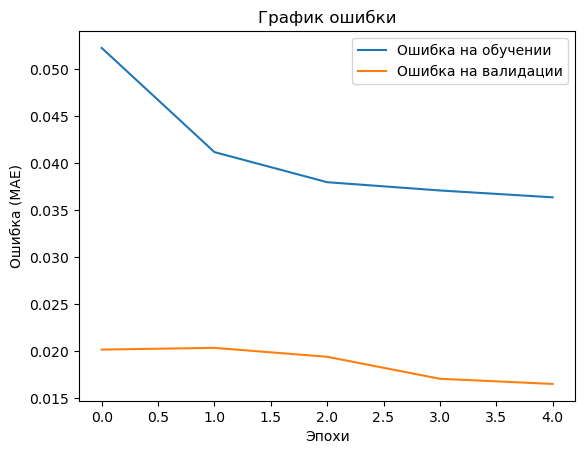

In [69]:
# Визуализация процесса обучения
plt.plot(history.history['loss'], label='Ошибка на обучении')
plt.plot(history.history['val_loss'], label='Ошибка на валидации')
plt.title('График ошибки')
plt.xlabel('Эпохи')
plt.ylabel('Ошибка (MAE)')
plt.legend()
plt.show()

In [70]:
# Прогнозирование на тестовых данных
y_pred = model.predict(X_test)

# Обратное масштабирование данных для сравнения с реальными значениями
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   


In [71]:
# Check the metrics on the full test data
mae = metrics.mean_absolute_error(y_test_original, y_pred_original)
mse = metrics.mean_squared_error(y_test_original, y_pred_original)
# mape = metrics.mean_absolute_percentage_error(y_test_original, y_pred_original)
mae

23.125069471028045

In [72]:
# Check the metrics on the deffined interval
min_interval = 1300
max_interval = 1350
mae = metrics.mean_absolute_error(y_test_original[min_interval:max_interval], y_pred_original[min_interval:max_interval])
# print(f"MSE на тестовых данных: {mse}")
mae

50.52459991693497

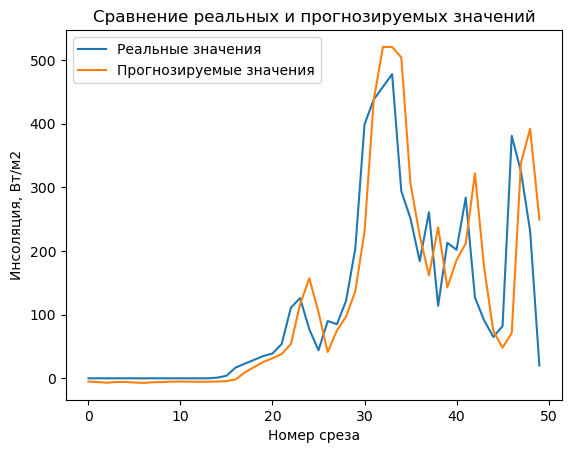

In [78]:
# Визуализация результатов на интервале
plt.plot(y_test_original[min_interval:max_interval], label='Реальные значения')
plt.plot(y_pred_original[min_interval:max_interval], label='Прогнозируемые значения')
plt.title('Сравнение реальных и прогнозируемых значений')
plt.xlabel('Номер среза')
plt.ylabel('Инсоляция, Вт/м2')
plt.legend()
plt.show()